# Processing pupil size data and epoching

When working with event-based recordings, it's often useful to extract and analyze data segments surrounding those events, rather than processing the entire recording. In mobile eye-tracking, such events could include stimulus presentations or the participant entering a specific area. In this tutorial, we'll demonstrate how to epoch data around these events using the `pyneon.Epochs` class, with the sample recording `screenFlash`.

In [1]:
import numpy as np
from pyneon import Recording, get_sample_data

# Create a Recording object
rec_dir = (
    get_sample_data("screenFlash")
    / "Timeseries Data + Scene Video"
    / "screenflash-54b2f924"
)
rec = Recording(rec_dir)
video = rec.video
blinks = rec.blinks
events = rec.events
eye_states = rec.eye_states

This recording features a participant observing a screen that flashes from black to white (flash duration = 0.75 s), with a 3-second interval between flashes. We expect the pupil to constrict in response to each flash, making this dataset ideal for demonstrating epoching. Here is how the flash appears to the participant:

Resetting video...
Resetting video...


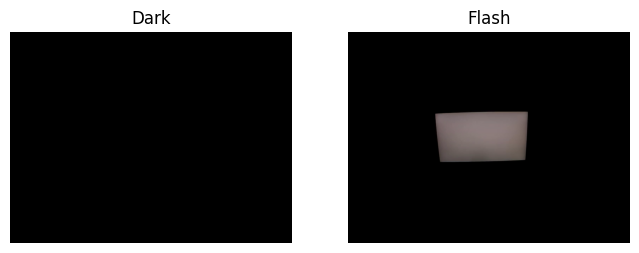

In [2]:
import matplotlib.pyplot as plt

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Visualize two frames from the video that correspond to the dark and flash periods
video.plot_frame(180, ax=axs[0], auto_title=False, show=False)
video.plot_frame(190, ax=axs[1], auto_title=False, show=False)
axs[0].set_title("Dark")
axs[1].set_title("Flash")
plt.show()

## Visualizing raw pupil size data and repairing blink artifacts

Let's inspect the raw pupil size data along with blink events. The shaded region shows when the screen is bright; dashed lines indicate the onset of blinks.

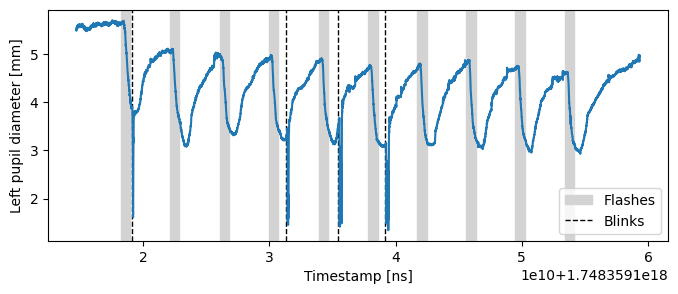

In [3]:
plt.figure(figsize=(8, 3))

# Visualize the flashes
flash_idx = np.where(events.data["name"] == "Flash onset")
for flash_start in events.start_ts[flash_idx]:
    dur = plt.axvspan(
        flash_start, flash_start + 0.75 * 1e9, color="lightgray", label="Flashes"
    )  # Each flash lasts 2 seconds

# Visualize the blinks
for blink_start in blinks.start_ts:
    line = plt.axvline(blink_start, color="k", linestyle="--", lw=1, label="Blinks")

# Plot the pupil data
(pupil_l,) = plt.plot(eye_states["pupil diameter left [mm]"])

plt.xlabel("Timestamp [ns]")
plt.ylabel("Left pupil diameter [mm]")
plt.legend(handles=[dur, line])
plt.show()

From the plot we can note:
- Pupil size decreases promptly after each change in screen brightness.
- The participant frequently blinks in response to flashes, and blinks introduce distinct transient artifacts in the pupil size measurement.
 
First, we’ll address blink artifacts using the `interpolate_events()` method of the `Stream` class. This method masks the data during events (in this case, blinks) and interpolates values around them, effectively removing the transient artifacts.

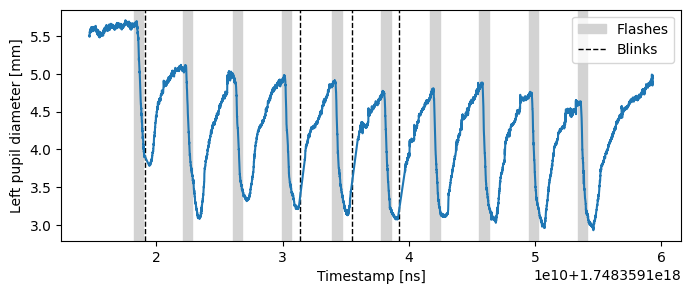

In [4]:
eye_states.interpolate_events(blinks, inplace=True)

plt.figure(figsize=(8, 3))

# Visualize the flashes
flash_idx = np.where(events.data["name"] == "Flash onset")
for flash_start in events.start_ts[flash_idx]:
    dur = plt.axvspan(
        flash_start, flash_start + 7.5 * 1e8, color="lightgray", label="Flashes"
    )  # Each flash lasts 2 seconds

# Visualize the blinks
for blink_start in blinks.start_ts:
    line = plt.axvline(blink_start, color="k", linestyle="--", lw=1, label="Blinks")

# Plot the pupil data
(pupil_l,) = plt.plot(eye_states["pupil diameter left [mm]"])

plt.xlabel("Timestamp [ns]")
plt.ylabel("Left pupil diameter [mm]")
plt.legend(handles=[dur, line])
plt.show()

## Defining Epochs: Creating the `times_df` DataFrame

In order to perform epoching, we require information about the timing and lenghts of epochs. Explicitly, every epoch requires:
- A reference time `t_ref`
- A time window defined by `t_before` and `t_after` to extract the data from
- An event `description` to annotate the epoch.

PyNeon's `Epochs` implementation allows epochs of variable lengths, where `t_before` and `t_after` may differ for each event. As a result, defining all epochs requires a DataFrame (`times_df`) with columns: `t_ref`, `t_before`, `t_after`, and `description`.

While constructing such a DataFrame by hand is possible, it's easier to generate one using event information from PyNeon `Events` objects. The `events_to_times_df` function streamlines this process by using the onsets of events and user-defined `t_before`/`t_after` values.

In this example, we’ll use `"Flash onset"` events, extracting 0.5 seconds before to 3 seconds after each event; the description is set to the event name automatically.

In [5]:
from pyneon import events_to_times_df, Epochs

# For complex events, such as those from `events.csv`, we need to specify the event name
flash_times_df = events_to_times_df(
    events, t_before=0.5, t_after=3, t_unit="s", event_name="Flash onset"
)

# Print the epoching-ready times_df
print("\nFlash times DataFrame:")
print(flash_times_df.head())


Flash times DataFrame:
                 t_ref   t_before     t_after  description
0  1748359118207381000  500000000  3000000000  Flash onset
1  1748359122083310000  500000000  3000000000  Flash onset
2  1748359126042722000  500000000  3000000000  Flash onset
3  1748359129933171000  500000000  3000000000  Flash onset
4  1748359133927133000  500000000  3000000000  Flash onset


## Creating `Epochs` objects

With the `times_df` DataFrame, we can create epochs by passing it along with the relevant `Stream` or `Events` data to the `Epochs` class.

In this example, we create two types of epochs to test two hypotheses:
- `eye_ep`: epochs from `eye_states` (a `Stream` object), containing pupil size. We hypothesize pupil size will decrease after each flash.
- `blink_ep`: epochs from `blinks` (an `Events` object), letting us check if blinks cluster after each flash.

In [6]:
eye_ep = Epochs(eye_states, flash_times_df)
blink_ep = Epochs(blinks, flash_times_df)
print(f"{len(eye_ep)} epochs created from {len(flash_times_df)} events")

10 epochs created from 10 events


C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 1.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 2.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 6.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 7.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 8.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 9.
  warnings.warn(f"No data found f

Given that we have very sparse blink events, it is not surprising that PyNeon emits a warning when creating the `blink_ep` epochs.

The `Epochs` class provides two key attributes (For details, see the [API reference](https://ncc-brain.github.io/PyNeon/reference/epochs.html)):
- `epochs`: a nested DataFrame, indexed by epoch number, with data for each epoch stored under the `data` column.
- `data`: (not to be confused with the `data` column in `Epochs.epochs`) a DataFrame in the same structure as the source, but annotated with epoch membership and timing information (`epoch index`, `epoch time`, and `epoch description`). As a flattened version of `Epochs.epochs`, `Epochs.data` may contain overlapping epochs; in such cases, the additional columns will only show information from the most recent epoch a time point belongs to. Therefore, we recommend primarily using `Epochs.epochs` for analysis.

In [7]:
print(f"Epochs.epochs contains:\n{eye_ep.epochs.columns}\n")
print(f"Its `data` column contains:\n{eye_ep.epochs.data[0].columns}\n")
print(f"Epochs.data contains:\n{eye_ep.data.columns}\n")

Epochs.epochs contains:
Index(['t_ref', 't_before', 't_after', 'description', 'data'], dtype='object')

Its `data` column contains:
Index(['pupil diameter left [mm]', 'pupil diameter right [mm]',
       'eyeball center left x [mm]', 'eyeball center left y [mm]',
       'eyeball center left z [mm]', 'eyeball center right x [mm]',
       'eyeball center right y [mm]', 'eyeball center right z [mm]',
       'optical axis left x', 'optical axis left y', 'optical axis left z',
       'optical axis right x', 'optical axis right y', 'optical axis right z',
       'eyelid angle top left [rad]', 'eyelid angle bottom left [rad]',
       'eyelid aperture left [mm]', 'eyelid angle top right [rad]',
       'eyelid angle bottom right [rad]', 'eyelid aperture right [mm]',
       'epoch time'],
      dtype='object')

Epochs.data contains:
Index(['pupil diameter left [mm]', 'pupil diameter right [mm]',
       'eyeball center left x [mm]', 'eyeball center left y [mm]',
       'eyeball center left z [mm]'

## Visualizing epoch data

The `plot()` method provides a convenient way to visualize data across epochs.

For `Epochs` created from a `Stream` (like eye states), specify the desired column to plot all across epochs in a single figure, colored by epoch index. We can observe from the following plot that pupil restriction occurs after each flash consistently, except for the first flash, likely due to a different baseline pupil size.

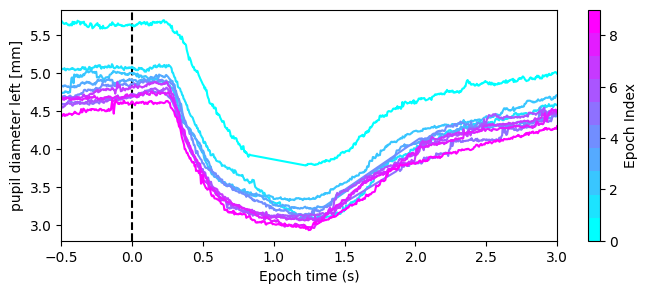

In [8]:
fig, ax = plt.subplots(figsize=(8, 3))
fig, ax = eye_ep.plot("pupil diameter left [mm]", ax=ax)

For `Events`-based `Epochs` (like blinks), simply call `plot()` with no arguments. Here, each event is displayed as a horizontal line spanning its duration, vertically sorted by epoch. We can see that blinks (N=4 in this example) tend to happen 1 to 1.5 seconds after each flash.

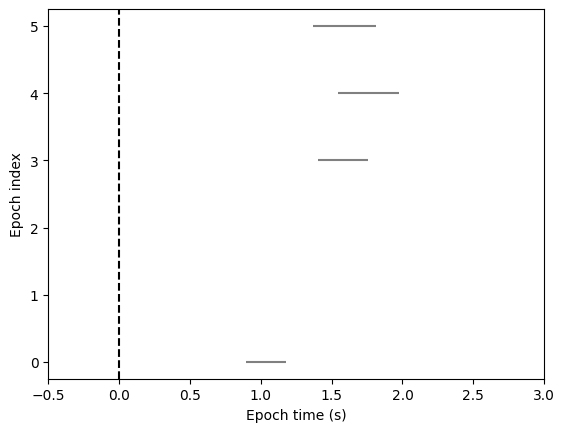

In [9]:
fig, ax = blink_ep.plot()

## Converting `Stream`-based `Epochs` to a Numpy array

Rather than viewing epochs as nested DataFrames, under the right conditions, you can convert an `Epochs` object to a 3D NumPy array useful for time-series analyses (like with [MNE-Python](https://mne.tools/stable/generated/mne.Epochs.html)).  

For this:
- The source must be a uniformly sampled `Stream` (constant intervals between samples).
- All epochs must have the same durations (`t_before` and `t_after` equal).

If these are not met, PyNeon will raise a `ValueError` when `to_numpy()` is called.

In [10]:
try:
    epochs_interp_np, info = eye_ep.to_numpy()
except Exception as e:
    print(f"Error converting to numpy: {e}")

Error converting to numpy: The source must be a uniformly-sampled Stream to convert to NumPy array.


To ensure compatibility, interpolate the `Stream` data prior to epoching, and maintain constant window sizes across epochs. The resulting array will be shaped `(n_epochs, n_channels, n_times)`.

In [11]:
# Create an epoch with the interpolated data
epochs_interp = Epochs(eye_states.interpolate(), flash_times_df)
epochs_interp_np, info = epochs_interp.to_numpy()

print(f"(n_epochs, n_channels, n_times) = {epochs_interp_np.shape}")
print(info.keys())

(n_epochs, n_channels, n_times) = (10, 20, 699)
dict_keys(['column_ids', 'epoch_times', 'nan_flag'])


C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:275: RuntimeWarning: NaN values were found in the data.
  warnings.warn("NaN values were found in the data.", RuntimeWarning)


In this case, we have 10 epochs, 20 data channels, and 699 time steps—consistent with the 200 Hz sampling rate and the 3.5-second epoch window. The `info` object contains lists of column IDs and epoch times. Now, the grand average is easily computed:

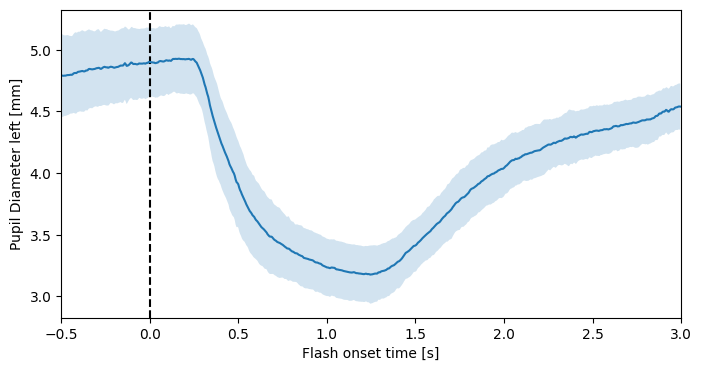

In [12]:
# Average the first channel (Pupil diameter left [mm]) across all epochs
pupil_mean = epochs_interp_np[:, 0, :].mean(axis=0)
pupil_std = epochs_interp_np[:, 0, :].std(axis=0)

plt.figure(figsize=(8, 4))

# Show a vertical line at 0
plt.axvline(x=0, color="k", linestyle="--")
# Plot the mean pupil diameter and standard deviation
plt.plot(info["epoch_times"], pupil_mean)
plt.fill_between(
    info["epoch_times"], pupil_mean - pupil_std, pupil_mean + pupil_std, alpha=0.2
)
plt.xlim(-0.5, 3)
plt.xlabel("Flash onset time [s]")
plt.ylabel("Pupil Diameter left [mm]")
plt.show()

## Baseline correction

Optionally, we can also perform `baseline_correction()` on the data to address global fluctuations in data. approach is to subtract the mean of a pre-event baseline (`method="mean"`). If there exists a linear trend in the baseline that extends into the entire epoch, `method="linear"` will fit and remove it.

Here, we apply `baseline_correction()` with `method="mean"` to compare pupil size relative to a 500 ms pre-flash baseline, centering pre-flash values around zero and reducing variance.

C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\epochs.py:275: RuntimeWarning: NaN values were found in the data.
  warnings.warn("NaN values were found in the data.", RuntimeWarning)


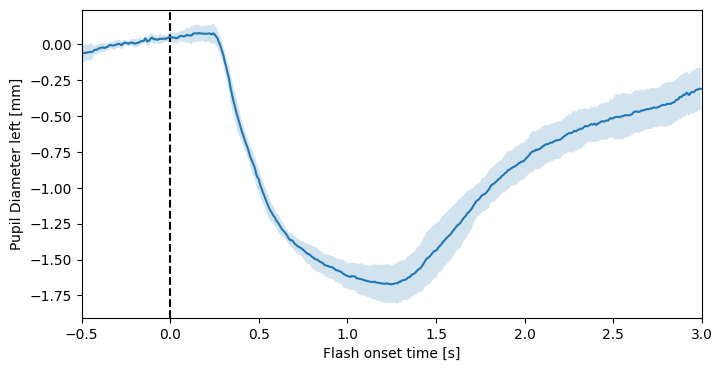

In [13]:
# Perform baseline correction
epochs_interp.baseline_correction(inplace=True, baseline=(-0.5, 0), method="mean")
epochs_interp_np, info = epochs_interp.to_numpy()

# Average the first channel (Pupil diameter left [mm]) across all epochs
pupil_mean = epochs_interp_np[:, 0, :].mean(axis=0)
pupil_std = epochs_interp_np[:, 0, :].std(axis=0)

plt.figure(figsize=(8, 4))

# Show a vertical line at 0
plt.axvline(x=0, color="k", linestyle="--")
# Plot the mean pupil diameter and standard deviation
plt.plot(info["epoch_times"], pupil_mean)
plt.fill_between(
    info["epoch_times"], pupil_mean - pupil_std, pupil_mean + pupil_std, alpha=0.2
)
plt.xlim(-0.5, 3)
plt.xlabel("Flash onset time [s]")
plt.ylabel("Pupil Diameter left [mm]")
plt.show()